### Build ACH Baselines
---

With label being simply `is_returned`
- FICO
- Deposit model v1
- LGBM model using v1 features

In [1]:
import json
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

#### Load data and define labels

In [2]:
modeling_df = pd.read_parquet('../../artifacts/20201005/modeling_df.parquet')
test_df = pd.read_parquet('../../artifacts/20201005/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 207), (88890, 207))

In [3]:
modeling_df.is_returned.value_counts()

False    108825
True       3774
Name: is_returned, dtype: int64

In [4]:
test_df.is_returned.value_counts()

False    84689
True      4201
Name: is_returned, dtype: int64

In [5]:
modeling_df['account_ending_balance'] = modeling_df['real_ending_balance']
modeling_df['days_since_first_transaction'] = modeling_df['days_since_first_deposit']
modeling_df['ach_target'] = modeling_df['is_returned']

#### Set features

In [6]:
# v1 features
v1_features = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'account_ending_balance', 'days_since_first_transaction'
              ]

v1_features_updated = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'real_ending_balance', # old 'account_ending_balance'
              'days_since_first_deposit' # old 'days_since_first_transaction'
              ]

In [7]:
# boruta features
# fsel = pkl.load(open('../../artifacts/20201005/feature_selector_dict.pkl', 'rb'))
# display(fsel.keys())
# boruta_fimp = fsel['record_boruta_importance']
# boruta_features = boruta_fimp.head(40).feature.to_list()
boruta_fimp = pd.read_csv('../../artifacts/20201005/boruta_importance_iter0.csv')
boruta_fimp.drop('Unnamed: 0', axis=1, inplace=True)

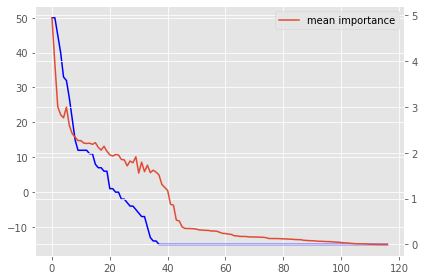

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(boruta_fimp.index, boruta_fimp.score, label='boruta score', c='blue')
ax2 = ax1.twinx()
ax2.plot(boruta_fimp.index, boruta_fimp.mean_importance, label='mean importance')
fig.tight_layout()
plt.legend()
plt.show()

In [9]:
boruta_features = boruta_fimp[boruta_fimp.score > -10].feature.to_list()
len(boruta_features), boruta_features

(33,
 ['first_deposit_amount',
  'vantage_score',
  'email_risk_score',
  'transaction_as_pct_of_balance',
  'nr_transactions_per_day',
  'credit_card_loan_amount',
  'phone_risk_score',
  'bcc7120',
  'rolling_trns_as_pct_of_bal',
  'quovo_available_bal',
  'fraud_score_2',
  'fraud_score_1',
  'plaid_max_avail_bal',
  'nr_transactions_30d_div_nr_past_transactions',
  'plaid_days_since_first_link',
  'fico_score',
  'quovo_largest_checking_or_savings_balance',
  'max_deposits_10d_div_mean_account_balance_30d',
  'transaction_as_pct_of_bal_min',
  'total_outstanding_balance',
  'deposits_ratio',
  'plaid_min_avail_bal',
  'all7120',
  'all8220',
  'address_risk_score',
  'quovo_min_avail_bal',
  'plaid_total_pos_bal',
  'total_tradelines_open',
  'sum_deposits_10d',
  'sum_deposits_30d',
  'nr_past_deposits',
  'mean_deposits_10d_div_mean_deposits',
  'mean_deposits_10d'])

#### Deposit V1 models

In [10]:
model_v1 = pkl.load(open('../../models/deposit-v1/money-deposit-risk-1567033961.pkl', 'rb'))

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
# make sure v1 features exist in modeling_df

modeling_df[model_v1.feature_name_].head()

,transaction_amount,account_ending_balance,fico_score,vantage_score,fraud_score_1,fraud_score_2,email_risk_score,phone_risk_score,all8220,iqt9415,...,bcx3423,stu5031,nr_direct_deposits,nr_past_returns,days_since_first_transaction,nr_transactions_per_day,transaction_as_pct_of_balance,rolling_trns_as_pct_of_bal,transaction_as_pct_of_bal_min,rolling_mean_acc_bal
10224161,88.0,35259.43,NaN,NaN,0.0163,0.428,0.197,0.005,NaN,NaN,...,NaN,NaN,51,0,847,0.773318,0.002502,0.010872,-0.085234,37835.792174
9871303,120.0,6439.15,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,785,0.442038,0.018990,0.018990,0.018990,6359.090000
10332885,120.0,6472.36,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,799,0.440551,0.018891,0.018891,0.018891,6938.360000
10818509,120.0,6592.44,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,812,0.434729,0.018540,0.018540,0.018540,6532.400000
11383098,120.0,6712.44,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,827,0.429262,0.018203,0.018203,0.018203,6652.440000


<AxesSubplot:>

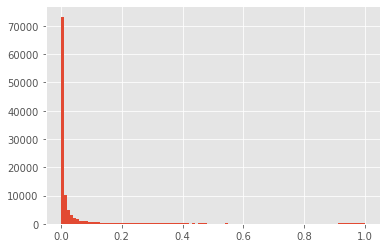

In [15]:
for feature in model_v1.feature_name_:
    modeling_df[feature] = modeling_df[feature].astype(float)
    
pred = model_v1.predict_proba(modeling_df[model_v1.feature_name_],
                              num_iteration=model_v1.best_iteration_)[:,1]
modeling_df['deposit_v1_pred'] = pred
modeling_df['deposit_v1_pred'].hist(bins=100)

#### Train model with deposit v1 features

In [16]:
seed = 12345
target_col = 'ach_target'
count_pos = modeling_df[target_col].sum()
count_neg = (~modeling_df[target_col]).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params = json.load(open('../../models/deposit-v1/params.json', 'rb'))
params['scale_pos_weight'] = pos_wgt_scaling_factor
params['verbosity'] = -1

In [17]:
pred, fimp_bl, model_bl, auc = train_lgb_baseline_grouped(modeling_df, v1_features_updated, 
                                                          params, target_col, seed=seed)
modeling_df['deposit_v1_updated_pred'] = pred

Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.94362	test's auc: 0.897059
[1000]	train's auc: 0.958649	test's auc: 0.893248
Early stopping, best iteration is:
[237]	train's auc: 0.929931	test's auc: 0.89871
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.940497	test's auc: 0.911984
[1000]	train's auc: 0.956403	test's auc: 0.9105
Early stopping, best iteration is:
[341]	train's auc: 0.932862	test's auc: 0.912292
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.943167	test's auc: 0.903226
[1000]	train's auc: 0.958245	test's auc: 0.899681
Early stopping, best iteration is:
[177]	train's auc: 0.923654	test's auc: 0.905268
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.943044	test's auc: 0.902261
[1000]	train's auc: 0.958341	test's auc: 0.899246
Early stopping, best iteration is:
[292]	train's auc: 0.932453	test's auc: 0.904968
Training until valid

,feature,importance,fold
0,transaction_amount,27686.647842,1
1,fico_score,34894.742687,1
2,vantage_score,581405.416416,1
3,fraud_score_1,12122.631611,1
4,fraud_score_2,4443.669285,1


(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

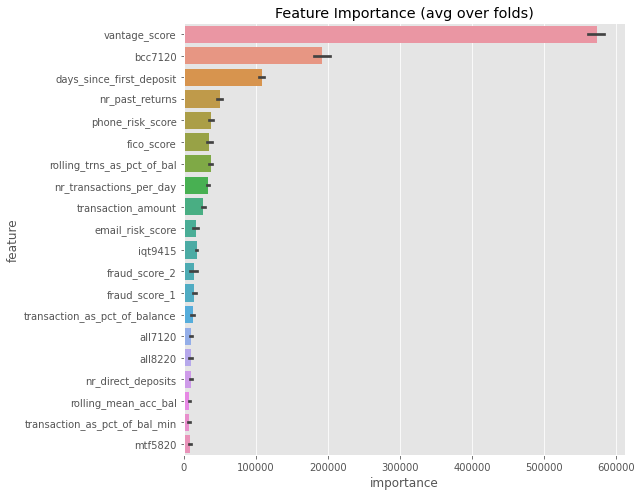

In [18]:
display(fimp_bl.head())
rdsplot.display_feature_importance(fimp_bl.feature, 
                                   fimp_bl.importance)

<AxesSubplot:>

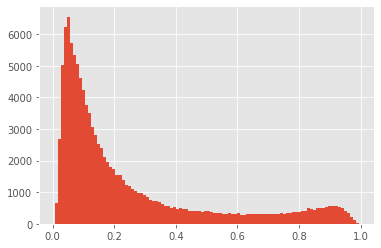

In [19]:
modeling_df['deposit_v1_updated_pred'].hist(bins=100)

#### Desposit v2 model Boruta selected features

In [20]:
seed = 12345

target_col = 'ach_target'
count_pos = modeling_df[target_col].sum()
count_neg = (~modeling_df[target_col]).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 3,
    "num_leaves" : 10,
    "learning_rate" : 0.02,
    "feature_fraction" : 0.6,
    "lambda_l1": 10,
    "lambda_l2": 10, 
    "min_data_in_leaf": 50,
    "scale_pos_weight": pos_wgt_scaling_factor,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : -1,
    "seed": seed
}

params_autogluon = {'num_boost_round': 1323,
                     'objective': 'binary',
                     'verbose': -1,
                     'boosting_type': 'gbdt',
                     'two_round': True,
                     'num_leaves': 11,
                     'lambda_l1': 14.596477090817569,
                     'lambda_l2': 13.460707339295784,
                     'min_data_in_leaf': 25,
                     'max_depth': 4,
                     'learning_rate': 0.05047151348160215,
                     'feature_fraction': 0.5130050456361218}


for p in params_autogluon:
    params[p] = params_autogluon[p]

In [21]:
pred_boruta, fimp_boruta, model_boruta, auc_boruta = train_lgb_baseline_grouped(modeling_df, boruta_features, 
                                                                                params, target_col, seed=seed)
modeling_df['boruta_pred_1005'] = pred_boruta

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.978341	test's auc: 0.92957
[1000]	train's auc: 0.989358	test's auc: 0.927402
Did not meet early stopping. Best iteration is:
[1323]	train's auc: 0.992538	test's auc: 0.926458
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.977249	test's auc: 0.934021
[1000]	train's auc: 0.988803	test's auc: 0.933303
Did not meet early stopping. Best iteration is:
[1323]	train's auc: 0.99216	test's auc: 0.93185
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. C

In [22]:
boruta_fimp.head()

,feature,score,mean_importance
0,first_deposit_amount,50.0,4.948260
1,vantage_score,50.0,3.943385
2,email_risk_score,45.0,3.008638
3,transaction_as_pct_of_balance,40.0,2.832464
4,nr_transactions_per_day,33.0,2.764047


(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

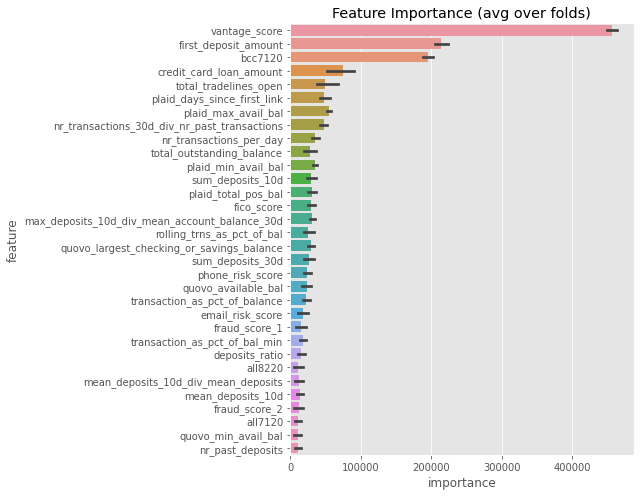

In [23]:
# # display all
# rdsplot.display_feature_importance(boruta_fimp.feature, 
#                                    boruta_fimp.mean_importance, 
#                                    max_n_features=60,
#                                    figsize=(16,16))

rdsplot.display_feature_importance(fimp_boruta.feature, 
                                   fimp_boruta.importance,
                                   max_n_features=-1)

<AxesSubplot:>

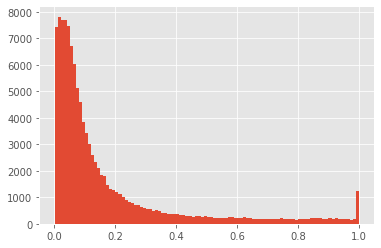

In [24]:
modeling_df['boruta_pred_1005'].hist(bins=100)

In [25]:
# import json
# with open('../../artifacts/ach-best-model-params.json', 'w') as f:
#     json.dump(params, f)

#### Customer Risk Score

In [26]:
customer_risk = pkl.load(open('../../models/customer-risk/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [27]:
targets = [{'target_col_name': 'target'}]

from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score',  # giact_time_since_last_link removed 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    # df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df



In [28]:
modeling_df_customer = modeling_df.copy()
modeling_df_customer = preprocess(modeling_df_customer)

In [31]:
modeling_df_customer[customer_risk.feature_name_].head()

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
10224161,100.0,NaN,NaN,0.197,0.428,0.9959,0.002502,37490.369268,0.005,0.9096,...,0.075000,NaN,4.440892e-16,0.0,NaN,0.0163,848,2,-1.0,-1.0
9871303,500.0,NaN,NaN,0.001,0.493,0.9954,0.018990,6295.078000,0.102,0.9096,...,0.200000,NaN,0.000000e+00,0.0,NaN,0.1072,837,2,-1.0,-1.0
10332885,500.0,NaN,NaN,0.001,0.493,0.9954,0.018891,6721.133750,0.102,0.9096,...,0.125000,NaN,0.000000e+00,0.0,NaN,0.1072,851,2,-1.0,-1.0
10818509,500.0,NaN,NaN,0.001,0.493,0.9954,0.018540,6817.627143,0.102,0.9096,...,0.142857,NaN,0.000000e+00,0.0,NaN,0.1072,864,2,-1.0,-1.0
11383098,500.0,NaN,NaN,0.001,0.493,0.9954,0.018203,6592.420000,0.102,0.9096,...,0.250000,NaN,0.000000e+00,0.0,NaN,0.1072,879,2,-1.0,-1.0


<AxesSubplot:>

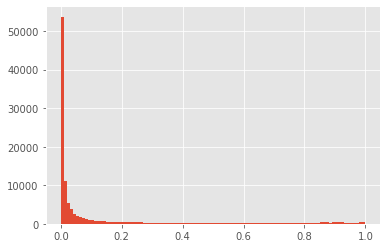

In [32]:
pred = customer_risk.predict_proba(modeling_df_customer[customer_risk.feature_name_],
                              num_iteration=customer_risk.best_iteration_)[:,1]
modeling_df['customer_pred'] = pred
modeling_df['customer_pred'].hist(bins=100)

### Comparing Results
---

In [33]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [34]:
metrics = get_pred_reports(modeling_df, target_col, 
                           ['deposit_v1_pred', 
                            'deposit_v1_updated_pred', 
                            'customer_pred', 
                            'boruta_pred_1005'])
metrics

,auc,ap,ks
deposit_v1_pred,85.04,27.63,56.85
deposit_v1_updated_pred,90.53,34.58,67.63
customer_pred,89.30,51.99,65.77
boruta_pred_1005,92.81,66.63,73.10


In [35]:
# for slides
metrics = get_pred_reports(modeling_df, target_col, 
                           ['deposit_v1_pred', 
                            'customer_pred',
                            'boruta_pred_1005'])
metrics

,auc,ap,ks
deposit_v1_pred,85.04,27.63,56.85
customer_pred,89.30,51.99,65.77
boruta_pred_1005,92.81,66.63,73.10


#### Plot Performances
---
To be honest the Blue Curve is a bit too good to be True... Double check there is no snooping bias

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

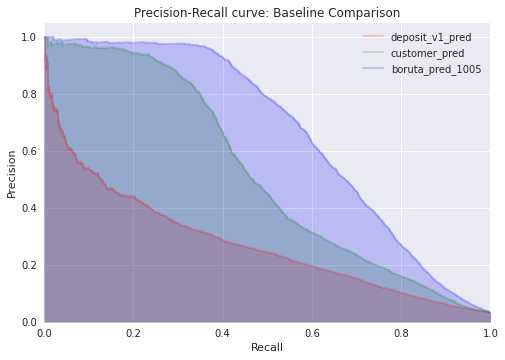

In [36]:
preds = [(modeling_df['deposit_v1_pred'], 'deposit_v1_pred'), 
         # (modeling_df['deposit_v1_updated_pred'], 'deposit_v1_updated_pred'),
         (modeling_df['customer_pred'], 'customer_pred'),
         (modeling_df['boruta_pred_1005'], 'boruta_pred_1005')]
title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

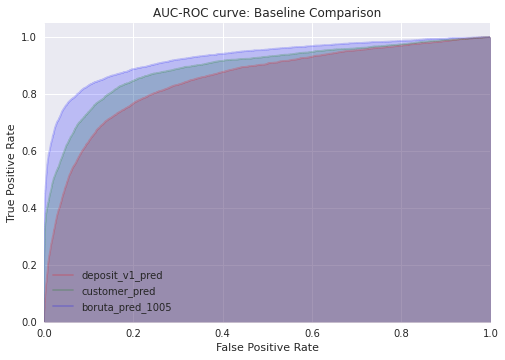

In [37]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

(<Figure size 1296x432 with 3 Axes>,
 array([<AxesSubplot:title={'center':'mean'}, xlabel='dt'>,
        <AxesSubplot:title={'center':'median'}, xlabel='dt'>,
        <AxesSubplot:title={'center':'count'}, xlabel='dt'>], dtype=object))

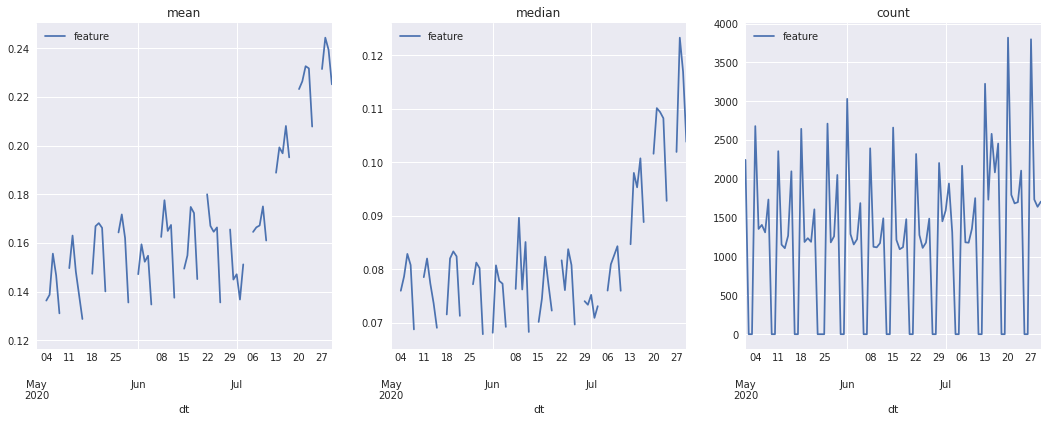

In [38]:
plot_feature_over_time(modeling_df.transaction_datetime, modeling_df.boruta_pred_1005)

### Comparing Results with valid FICO for reporting
---

In [43]:
df_w_fico = modeling_df[(~modeling_df.fico_score.isna()) & (modeling_df.fico_score <= 850)]
# logically good fico score -> lower fraud prob
# flip the direction to match with target 

df_w_fico['fico_pred'] = -df_w_fico['fico_score']  
metrics = get_pred_reports(df_w_fico, target_col, 
                           ['fico_pred', 
                            'deposit_v1_pred', 
                            'customer_pred',
                            'boruta_pred_1005'])
metrics

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,auc,ap,ks
fico_pred,85.39,18.11,60.56
deposit_v1_pred,83.70,23.33,54.38
customer_pred,88.42,48.07,63.72
boruta_pred_1005,92.10,63.63,71.24


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

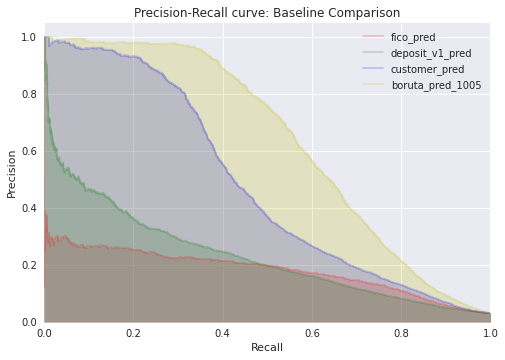

In [44]:
preds = [(df_w_fico['fico_pred'], 'fico_pred'),
         (df_w_fico['deposit_v1_pred'], 'deposit_v1_pred'), 
         (df_w_fico['customer_pred'], 'customer_pred'),
         (df_w_fico['boruta_pred_1005'], 'boruta_pred_1005')]
title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(df_w_fico[target_col], preds,
                   title=title, colors = ['r', 'g', 'b', 'y'])

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

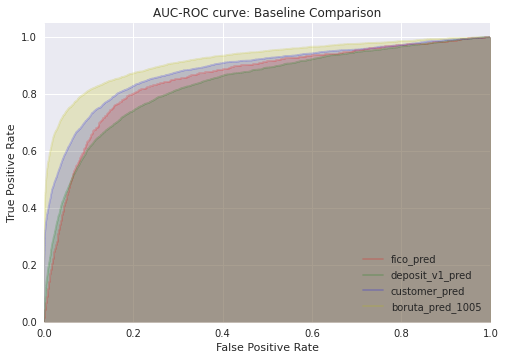

In [45]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(df_w_fico[target_col], preds,
                   title=title, colors = ['r', 'g', 'b', 'y'])

#### Compare with current best
---

In [46]:
# preds = [(modeling_df['deposit_v1_pred'], 'deposit_v1_pred'), 
#          (modeling_df['boruta_pred_0920'], 'boruta_pred_0920'),
#          (modeling_df['boruta_pred_1005'], 'boruta_pred_1005')]
# title = 'Precision-Recall curve: Baseline Comparison'
# plot_pr_curve_mult(modeling_df[target_col], preds,
#                    title=title, colors = ['r', 'g', 'b'])

In [47]:
# title = 'AUC-ROC curve: Baseline Comparison'
# plot_auc_curve_mult(modeling_df[target_col], preds,
#                    title=title, colors = ['r', 'g', 'b'])

#### Save to artifacts

In [48]:
modeling_df.to_parquet('../../artifacts/20201005/modeling_df_w_baseline_preds.parquet', 
                       engine='pyarrow')

In [49]:
models_baseline = {'boruta_baseline': model_boruta}
pkl.dump(models_baseline, open('../../artifacts/20201005/models_baseline.pkl', 'wb'))

In [50]:
pkl.dump(boruta_features, open('../../artifacts/20201005/boruta_features.pkl', 'wb'))
pkl.dump(fimp_boruta, open('../../artifacts/20201005/fimp_boruta.pkl', 'wb'))